In [ ]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn jupyterlab pydicom
!pip3 install scikit-image tqdm tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pydicom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models # type: ignore
from skimage.transform import resize
from tqdm import tqdm

# Load the 500-image dataset from dataset
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

print(f"Loaded 500-image dataset from dataset")
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

train_df.head()

2025-12-03 17:53:34.230809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded 500-image dataset from dataset
Training set: 350 images
Validation set: 75 images
Test set: 75 images


,subject_id,image_path,mask_path,image_shape,mask_nonzero_pixels,tumor_ratio,original_image_path,original_mask_path
0,Calc-Training_P_00105_LEFT_MLO,dataset/images/Calc-Training_P_00105_LEFT_MLO_...,dataset/masks/Calc-Training_P_00105_LEFT_MLO_m...,"(5491, 3361)",191829,0.010394,./CBIS-DDSM/Calc-Training_P_00105_LEFT_MLO/08-...,./CBIS-DDSM/Calc-Training_P_00105_LEFT_MLO_1/0...
1,Mass-Test_P_01614_LEFT_MLO,dataset/images/Mass-Test_P_01614_LEFT_MLO_imag...,dataset/masks/Mass-Test_P_01614_LEFT_MLO_mask.dcm,"(6241, 3271)",26490,0.001298,./CBIS-DDSM/Mass-Test_P_01614_LEFT_MLO/10-04-2...,./CBIS-DDSM/Mass-Test_P_01614_LEFT_MLO_1/09-27...
2,Calc-Training_P_00121_LEFT_MLO,dataset/images/Calc-Training_P_00121_LEFT_MLO_...,dataset/masks/Calc-Training_P_00121_LEFT_MLO_m...,"(4792, 3032)",29813,0.002052,./CBIS-DDSM/Calc-Training_P_00121_LEFT_MLO/08-...,./CBIS-DDSM/Calc-Training_P_00121_LEFT_MLO_1/0...
3,Calc-Training_P_01526_RIGHT_CC,dataset/images/Calc-Training_P_01526_RIGHT_CC_...,dataset/masks/Calc-Training_P_01526_RIGHT_CC_m...,"(5960, 3928)",1797021,0.076760,./CBIS-DDSM/Calc-Training_P_01526_RIGHT_CC/08-...,./CBIS-DDSM/Calc-Training_P_01526_RIGHT_CC_1/0...
4,Mass-Test_P_01666_RIGHT_MLO,dataset/images/Mass-Test_P_01666_RIGHT_MLO_ima...,dataset/masks/Mass-Test_P_01666_RIGHT_MLO_mask...,"(4632, 3032)",67260,0.004789,./CBIS-DDSM/Mass-Test_P_01666_RIGHT_MLO/10-04-...,./CBIS-DDSM/Mass-Test_P_01666_RIGHT_MLO_1/10-0...


In [3]:
IMG_SIZE = 256
CHANNELS = 1    # Black and White images

def load_dicom_image(file_path):
    try:
        file_path = Path(file_path)
        if file_path.exists() and file_path.is_file():
            ds = pydicom.dcmread(str(file_path))
            arr = ds.pixel_array
            # Normalize to 0-255
            if arr.dtype != np.uint8:
                arr = arr.astype(np.float32)
                arr -= arr.min()
                if arr.max() > 0:
                    arr = arr / arr.max()
                arr = (arr * 255).astype(np.uint8)
            return arr
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return None


def preprocess_image(image_path, target_size=IMG_SIZE):
    img = load_dicom_image(image_path)
    if img is None:
        return None
    
    # Resize
    img_resized = resize(img, (target_size, target_size), preserve_range=True, anti_aliasing=True)
    
    # Normalize to [0, 1]
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    return img_normalized


def preprocess_mask(mask_path, target_size=IMG_SIZE):
    mask = load_dicom_image(mask_path)
    if mask is None:
        return None
    
    # Resize
    mask_resized = resize(mask, (target_size, target_size), preserve_range=True, anti_aliasing=False)
    
    # Binarize (threshold at 0.5 after normalization)
    mask_binary = (mask_resized > 127).astype(np.float32)
    
    return mask_binary


def load_batch(df, batch_size=16, target_size=IMG_SIZE):
    images = []
    masks = []
    
    for idx, row in df.iterrows():
        img = preprocess_image(row['image_path'], target_size)
        mask = preprocess_mask(row['mask_path'], target_size)
        
        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)
        
        if len(images) >= batch_size:
            break
    
    # Convert to numpy arrays with shape (batch, height, width, channels)
    images = np.array(images)[..., np.newaxis]  # Add channel dimension
    masks = np.array(masks)[..., np.newaxis]    # Add channel dimension
    
    return images, masks


print("Preprocessing functions defined")
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Image normalization: [0, 1]")
print(f"Mask format: Binary (0 or 1)")

Preprocessing functions defined
Target image size: 256x256
Image normalization: [0, 1]
Mask format: Binary (0 or 1)



Preprocessing test successful!
Images shape: (3, 256, 256, 1)
Masks shape: (3, 256, 256, 1)
Image value range: [0.000, 1.000]
Mask unique values: [0. 1.]


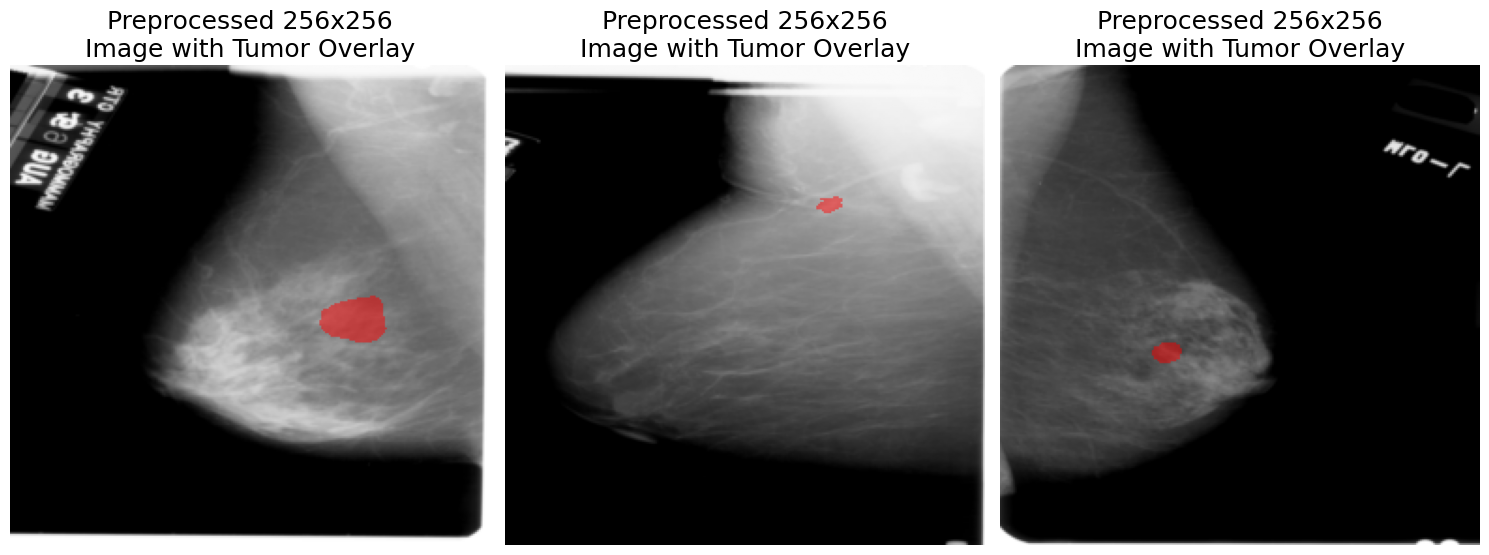

In [4]:
# Test preprocessing with a sample batch
sample_images, sample_masks = load_batch(train_df, batch_size=3)

print(f"\nPreprocessing test successful!")
print(f"Images shape: {sample_images.shape}")
print(f"Masks shape: {sample_masks.shape}")
print(f"Image value range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")
print(f"Mask unique values: {np.unique(sample_masks)}")

# Visualize preprocessed samples with overlay (like cell 3)
fig, axes = plt.subplots(1, 3, figsize=(15, 12))

for i in range(3):
    ax = axes[i]
    
    # Display preprocessed image
    ax.imshow(sample_images[i, :, :, 0], cmap='gray')
    
    # Overlay preprocessed mask with transparency
    mask_colored = np.zeros((*sample_masks[i, :, :, 0].shape, 4))  # RGBA
    mask_colored[:, :, 0] = 1.0  # Red channel
    mask_colored[:, :, 3] = sample_masks[i, :, :, 0] * 0.5  # Alpha channel
    
    ax.imshow(mask_colored)

    ax.set_title(f"Preprocessed {IMG_SIZE}x{IMG_SIZE}\nImage with Tumor Overlay", fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def build_unet(input_shape=(256, 256, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (Compressing Path)
    # Block 1
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    # Block 2
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Block 3
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    # Block 4
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (Expanding Path)
    # Block 6
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    # Block 7
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    # Block 8
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    # Block 9
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=1)
print(f"\nModel Summary:")
model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)